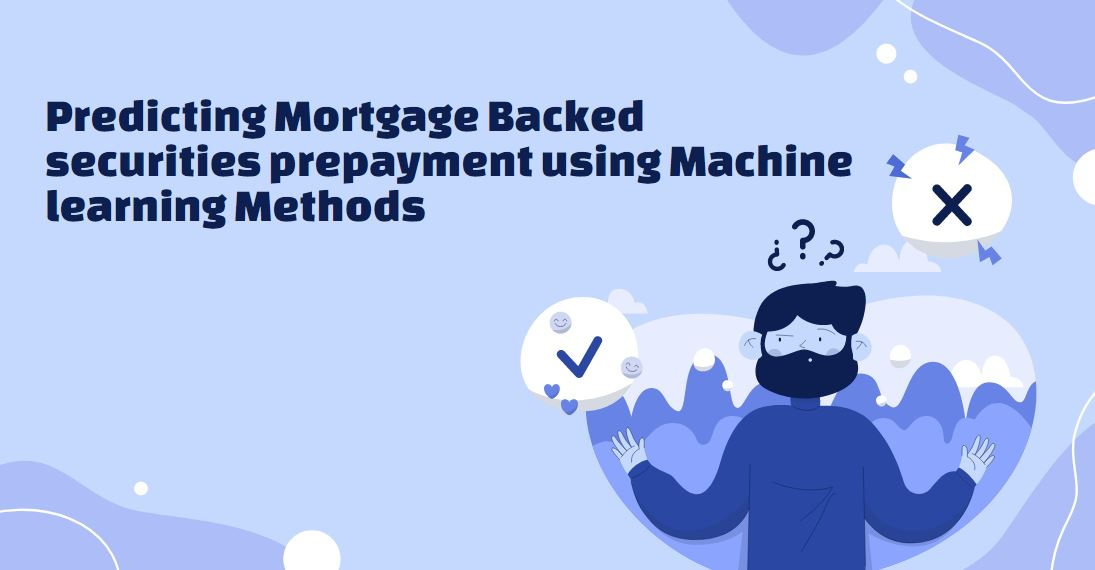

# **Description of the project**

This project specifically focuses on finding an alternative method to predict mortgage prepayment risk of residential mortgage loans by using different machine learning techniques.

**We have used**:  [Freddie Mac’s Single Family Loan- Level Dataset](https://http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)

This dataset originally contains 95 features divided as **Original data** and **Performance data**.

In the dataset we make the use of **27**datacolumns. 

The description of the dataset can be found in the following document:
http://www.freddiemac.com/fmac-resources/research/pdf/user_guide.pdf


In [78]:
# importing all the libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix,roc_auc_score, roc_curve

from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# loading the data

mortgage_data = pd.read_csv("/content/drive/MyDrive/loandataset/loan_level_500k.csv")

In [81]:
# Let's view the top 5 head records in the dataset

mortgage_data.head()


,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
0,669.0,200206,N,202901,NaN,0.0,1.0,O,80.0,33.0,162000,80.0,7.120,R,N,FRM,WV,SF,26100.0,F199Q1000004,P,320,2.0,Other sellers,Other servicers,True,False
1,732.0,199904,N,202903,17140.0,0.0,1.0,O,25.0,10.0,53000,25.0,6.500,R,N,FRM,OH,SF,45200.0,F199Q1000005,N,360,1.0,Other sellers,Other servicers,True,False
2,679.0,200208,N,202902,15940.0,30.0,1.0,O,91.0,48.0,133000,91.0,6.750,R,N,FRM,OH,SF,44700.0,F199Q1000007,P,319,1.0,Other sellers,Other servicers,True,False
3,721.0,200209,N,202902,38060.0,0.0,1.0,O,39.0,13.0,174000,39.0,6.625,T,N,FRM,AZ,SF,85200.0,F199Q1000013,N,318,2.0,Other sellers,Other servicers,True,False
4,618.0,200210,N,202902,10420.0,25.0,1.0,O,85.0,24.0,122000,85.0,6.375,R,N,FRM,OH,SF,44200.0,F199Q1000015,N,317,2.0,Other sellers,Other servicers,True,False


In [82]:
# Shape of the dataset

mortgage_data.shape

(500137, 27)

We have more than 500 thousand  records in the dataset with 27 columns.

In [83]:
mortgage_data.dtypes.value_counts()

object     11
float64    10
int64       4
bool        2
dtype: int64

From this analysis we can say that we have about 14 numerical values, 11 values are of object type i.e. categorical and 2 of them have boolean content in it.

In [84]:
mortgage_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500137 entries, 0 to 500136
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CREDIT_SCORE                      497426 non-null  float64
 1   FIRST_PAYMENT_DATE                500137 non-null  int64  
 2   FIRST_TIME_HOMEBUYER_FLAG         369578 non-null  object 
 3   MATURITY_DATE                     500137 non-null  int64  
 4   METROPOLITAN_STATISTICAL_AREA     429988 non-null  float64
 5   MORTGAGE_INSURANCE_PERCENTAGE     449089 non-null  float64
 6   NUMBER_OF_UNITS                   500134 non-null  float64
 7   OCCUPANCY_STATUS                  500137 non-null  object 
 8   ORIGINAL_COMBINED_LOAN_TO_VALUE   500124 non-null  float64
 9   ORIGINAL_DEBT_TO_INCOME_RATIO     485208 non-null  float64
 10  ORIGINAL_UPB                      500137 non-null  int64  
 11  ORIGINAL_LOAN_TO_VALUE            500128 non-null  f

#### <b>IMPORTANT</b>

Before performing the EDA I want to drop four columns that seems really useless and doing nothing except for increasing the dimension of dataset.

These columns are:

1. 'FIRST_PAYMENT_DATE',
2. 'MATURITY_DATE',
3. 'LOAN_SEQUENCE_NUMBER',
4. 'METROPOLITAN_STATISTICAL_AREA',
5. 'OCCUPANCY_STATUS',
7. 'CHANNEL',
8. 'PRODUCT_TYPE',
9. 'PROPERTY_STATE',
10. 'PROPERTY_TYPE',
11. 'NUMBER_OF_BORROWERS',
12. 'LOAN_PURPOSE','PREPAYMENT_PENALTY_MORTGAGE_FLAG',
13. 'SELLER_NAME',
14. 'SERVICER_NAME',
15. 'POSTAL_CODE'

In [85]:
# dropping the columns

mortgage_data.drop(['FIRST_PAYMENT_DATE','MATURITY_DATE','LOAN_SEQUENCE_NUMBER','METROPOLITAN_STATISTICAL_AREA','OCCUPANCY_STATUS','CHANNEL','PRODUCT_TYPE','PROPERTY_STATE','PROPERTY_TYPE','NUMBER_OF_BORROWERS','LOAN_PURPOSE','PREPAYMENT_PENALTY_MORTGAGE_FLAG',
'SELLER_NAME',
'SERVICER_NAME',
'POSTAL_CODE'], axis = 1,inplace = True)

In [86]:
# Remaining column in the datset

mortgage_data.columns

Index(['CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG',
       'MORTGAGE_INSURANCE_PERCENTAGE', 'NUMBER_OF_UNITS',
       'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'ORIGINAL_DEBT_TO_INCOME_RATIO',
       'ORIGINAL_UPB', 'ORIGINAL_LOAN_TO_VALUE', 'ORIGINAL_INTEREST_RATE',
       'ORIGINAL_LOAN_TERM', 'PREPAID', 'DELINQUENT'],
      dtype='object')

After dropping **15** columns we have remaining **12** columns on which we will further carry on our data preprocessing.

These columns are:

1. CREDIT_SCORE, 
2. FIRST_TIME_HOMEBUYER_FLAG',
3. MORTGAGE_INSURANCE_PERCENTAGE,
4. NUMBER_OF_UNITS,
5. ORIGINAL_COMBINED_LOAN_TO_VALUE,
6. ORIGINAL_DEBT_TO_INCOME_RATIO,
7. ORIGINAL_UPB,
8. ORIGINAL_LOAN_TO_VALUE, 
9. ORIGINAL_INTEREST_RATE,
10. ORIGINAL_LOAN_TERM, 
11. PREPAID, 
12. DELINQUENT

## **Adding two new features to the dataset**

Here we introduced two new feature in the dataset named **'LTV_range'** and **'CreditScore_range'** derieved from **'ORIGINAL_LOAN_TO_VALUE'** and **'CREDIT_SCORE'** respectively.

In case of "ORIGINAL_LOAN_TO_VALUE" we can see that it ranges from 0 to 100. Now we will divide these continuous value into three parts and they are 
* Low(0-50), 
* medium(50-80) and 
* high(above 80)

In case of 'CREDIT_SCORE the minimum value for credit score is 300 and the maximum value is almost 850. So let's bin the value with the binning difference of 200. So 300-500,500-700,700-800.

* 300-500 = 1 [ Lowest value for credit score ]
* 500-700 = 2 [ medium value for credit score ]
* 700-900 = 3 [ Highest valye for credirt score ]



In [87]:
#define bins for new LTV_range
bins = [0, 50, 80, 120]

#name of groups
groups = ['Low', 'Med', 'High']

mortgage_data['LTV_range'] = pd.cut(mortgage_data['ORIGINAL_LOAN_TO_VALUE'], bins=bins, labels=groups)

mortgage_data[['LTV_range', 'ORIGINAL_LOAN_TO_VALUE']].head()

,LTV_range,ORIGINAL_LOAN_TO_VALUE
0,Med,80.0
1,Low,25.0
2,High,91.0
3,Low,39.0
4,High,85.0


In [88]:
mortgage_data['LTV_range'].value_counts()
print("The data type of LTV_range is", mortgage_data['LTV_range'].dtypes)

The data type of LTV_range is category


In [89]:
#define bins for CreditScore_range
bins2 = [300, 500, 700, 900]

#name of groups
groups2 = [1, 2, 3]

mortgage_data['CreditScore_range'] = pd.cut(mortgage_data['CREDIT_SCORE'], bins=bins2, labels=groups2)

mortgage_data[['CreditScore_range', 'CREDIT_SCORE']].head()

,CreditScore_range,CREDIT_SCORE
0,2,669.0
1,3,732.0
2,2,679.0
3,3,721.0
4,2,618.0


In [90]:
mortgage_data['CreditScore_range'].value_counts()
print("The data type of CreditScore_range is", mortgage_data['CreditScore_range'].dtypes)

The data type of CreditScore_range is category


In [91]:
mortgage_data['CreditScore_range'].value_counts()

3    304667
2    192070
1       178
Name: CreditScore_range, dtype: int64

In [92]:
#changing the data tyoe of CreditScore_range as float

# mortgage_data['CreditScore_range'] = mortgage_data['CreditScore_range'].astype('float64')

In [93]:
#mortgage_data['CreditScore_range'].dtypes

# **Data Analysis Phase [EDA]**

In this phase I will analyze the data to find out:

* Missing Values
* All the Numerical Varibles
* Distribution of the Numerical Variables
* Categorical varibles
* Outliers
* Relationship between Independent and dependent feature

In [94]:
# Let's find out the missing values in our dataset

missing_value = mortgage_data.isnull().sum()
missing_value

CREDIT_SCORE                         2711
FIRST_TIME_HOMEBUYER_FLAG          130559
MORTGAGE_INSURANCE_PERCENTAGE       51048
NUMBER_OF_UNITS                         3
ORIGINAL_COMBINED_LOAN_TO_VALUE        13
ORIGINAL_DEBT_TO_INCOME_RATIO       14929
ORIGINAL_UPB                            0
ORIGINAL_LOAN_TO_VALUE                  9
ORIGINAL_INTEREST_RATE                  0
ORIGINAL_LOAN_TERM                      0
PREPAID                                 0
DELINQUENT                              0
LTV_range                               9
CreditScore_range                    3222
dtype: int64

So,from the observation we can see quiet a lot of missing values. Now we will find out the number of columns with missing values.

**Analysis**:

In case of our dataset we have 7 columns with missing rows.


* CREDIT_SCORE                         2711
* FIRST_TIME_HOMEBUYER_FLAG          130559
* MORTGAGE_INSURANCE_PERCENTAGE       51048
* NUMBER_OF_UNITS                         3
* ORIGINAL_COMBINED_LOAN_TO_VALUE        13
* ORIGINAL_DEBT_TO_INCOME_RATIO       14929
* ORIGINAL_LOAN_TO_VALUE                  9
* LTV_range                               9
* CreditScore_range                    3222

In [95]:
# Let's find out the total percentage of missing value
total_cell = np.product(mortgage_data.shape)

total_missing_values = sum(mortgage_data.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

# percent of total missing values
percent_missing = (total_missing_values/total_cell) * 100

print("Total missing values are",percent_missing)


Total missing values are 2.4360610906897224


#### <b> Analysis: </b>

Almost 3% of data is missing in our dataset.

#### <b>Let's observe the feature datatypes and distribution of the data with some simple analysis technique and visulization.</b>

In [96]:
# list of numerical variables
numerical_features = [feature for feature in mortgage_data.columns if mortgage_data[feature].dtypes != 'O']

print("The list of numerical feature are: \n")
print(numerical_features)
print('\n Number of numerical variables: ', len(numerical_features))

The list of numerical feature are: 

['CREDIT_SCORE', 'MORTGAGE_INSURANCE_PERCENTAGE', 'NUMBER_OF_UNITS', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'ORIGINAL_UPB', 'ORIGINAL_LOAN_TO_VALUE', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_LOAN_TERM', 'PREPAID', 'DELINQUENT', 'LTV_range', 'CreditScore_range']

 Number of numerical variables:  13


In [97]:
# list of categorical variables

categorical_features = [feature for feature in mortgage_data.columns if mortgage_data[feature].dtypes == 'O']
print("The list of categorical feature are: \n")
print(categorical_features)
print('\nNumber of categorical variables: ', len(categorical_features))

The list of categorical feature are: 

['FIRST_TIME_HOMEBUYER_FLAG']

Number of categorical variables:  1


In [98]:
# List of continuous variables

continuous_feature = [feature for feature in numerical_features if len(mortgage_data[feature].unique()) > 25]
print("The list of continuous feature are: \n")
print(continuous_feature)
print("\n The continuous features are : ",len(continuous_feature))

The list of continuous feature are: 

['CREDIT_SCORE', 'MORTGAGE_INSURANCE_PERCENTAGE', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'ORIGINAL_UPB', 'ORIGINAL_LOAN_TO_VALUE', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_LOAN_TERM']

 The continuous features are :  8


In [99]:
# List of discrete variables

discrete_feature = [feature for feature in numerical_features if len(mortgage_data[feature].unique()) < 25]
print("The list of discrete feature are: \n")
print(discrete_feature)
print("\n The discrete features are : ",len(discrete_feature))

The list of discrete feature are: 

['NUMBER_OF_UNITS', 'PREPAID', 'DELINQUENT', 'LTV_range', 'CreditScore_range']

 The discrete features are :  5


In [100]:
## Creating a reusable function to show the feature distribution of the given dataset

def plot_continuous_feature(cont_feature):
  for feature in cont_feature:
    data = mortgage_data.copy()
    sns.distplot(a = data[feature],kde = True)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature.title() + " " + "Distribution")
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


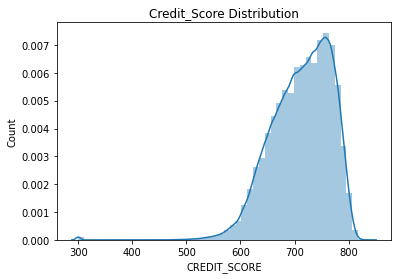

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


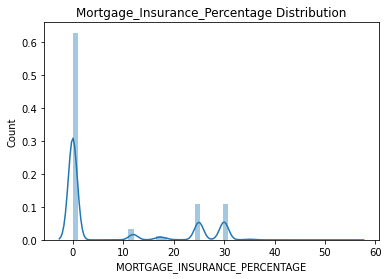

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


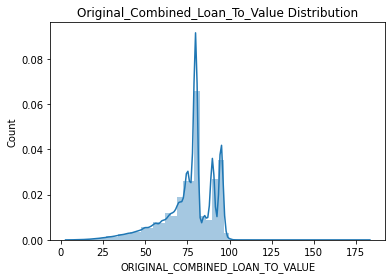

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


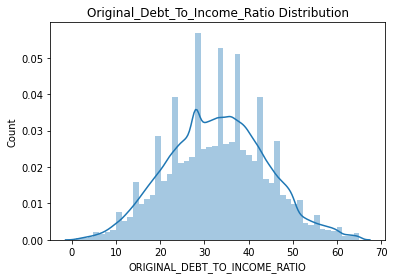

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


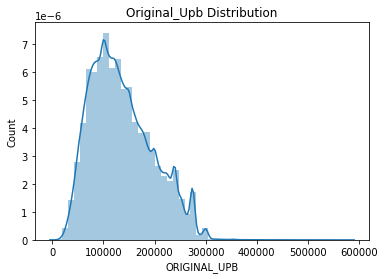

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


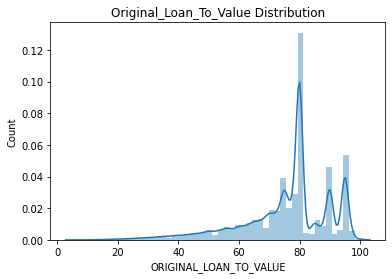

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


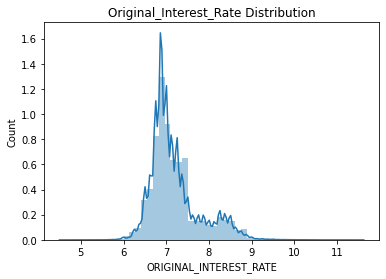

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


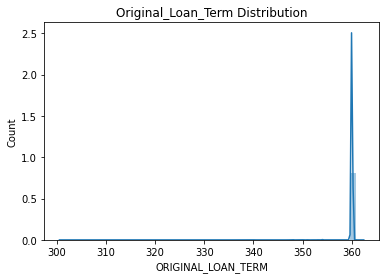

In [101]:
## Calling the function

plot_continuous_feature(continuous_feature)

#### <b> Analysis :</b>

Let's decode the distribution of these 8 continuous features one by one:

From above observation:

* **Credit score(left skewed)**
The credit score feature doesn't follow **gaussian distribution** rather it is slightly **leftskewed**. From the distribution plot we can say that the credit score value of many borrowers mainly lies in between the range of 500-800.

* **MORTGAGE_INSURANCE_PERCENTAGE**
The Mortgage insurance percentage feature values are very sparsely distributed. Most of the borrowers Mortage insurance percentage has % slightly more than 0%. Besides that the percentage distribution doesn't exceed from more than 30-35%.

* **ORIGINAL_COMBINED_LOAN_TO_VALUE**
In this feature the combined loan to value of the borrowers is mainly distributed between 25% to 100% most of the borrowers have CLTV around 75%.


* **ORIGINAL_DEBT_TO_INCOME_RATIO**
The values in this feature are very well distributed and thus follows the normal distribution the ratio value ranges from 0 to 70.

* **ORIGINAL_UPB**
This values in this features are mostly right skewed. This feature is actually UPB of the mortgage on the note date. Most of the value lies in between 0 to 300000.

* **ORIGINAL_LOAN_TO_VALUE**
This feature also doesn't follow a normal distribution. The value range form 0 t0 100% and most of the borrowers has around 80 to 85% of LTV.

* **ORIGINAL_INTEREST_RATE**
This feature somewhat follows gaussian distribution and the Interest rate mostly lies in between 6-9%.

* **ORIGINAL_LOAN_TERM**
This feature is obtained by subtracting the Maturity Date from the first payment date i.e. 

Original_loan_term = (Loan
Maturity Date (MM/YY)
– Loan First Payment
Date (MM/YY) + 1

The dataset only contains the loan tern in between 300 to 420 and rest of the loan terms are all excluded from the dataset.



####**Observing the distribution of categorical feature**

In [102]:
def feature_countplot(cat_feature):
  for feature in cat_feature:
    data = mortgage_data.copy()
    plt.figure(figsize = (10,10))
    sns.countplot(x = feature, data = data)
    plt.xlabel(feature)  
    plt.ylabel("count")
    plt.title(feature.title() + " " + "Count distribution with the output")
    plt.show()

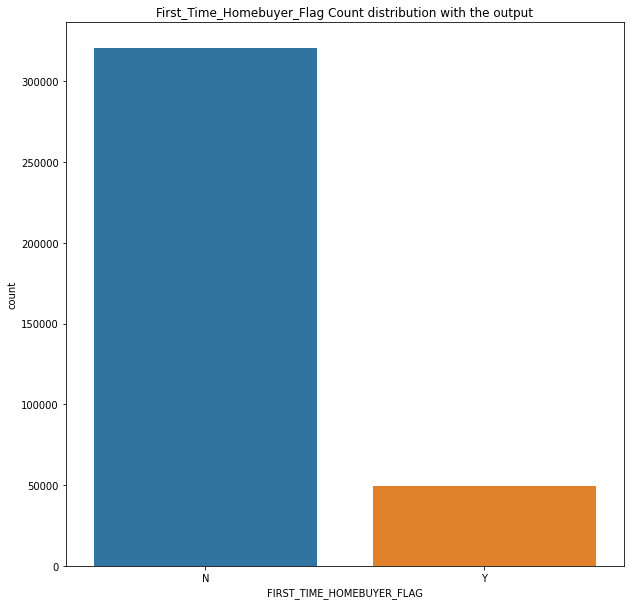

In [103]:
feature_countplot(categorical_features)

#### **Analysis:**

The **'FIRST_TIME_HOMEBUYER_FLAG'** feature is a categorical feature with two categories either the borrowers are the first time homebuyer or not. This feature also has many missing value that depicts that some of the borrowers record are not available or they are not aplicable.

From the above count plot we can say that most of the borrowers are not first time homebuyer.

#### **Analysing the features with discrete values**

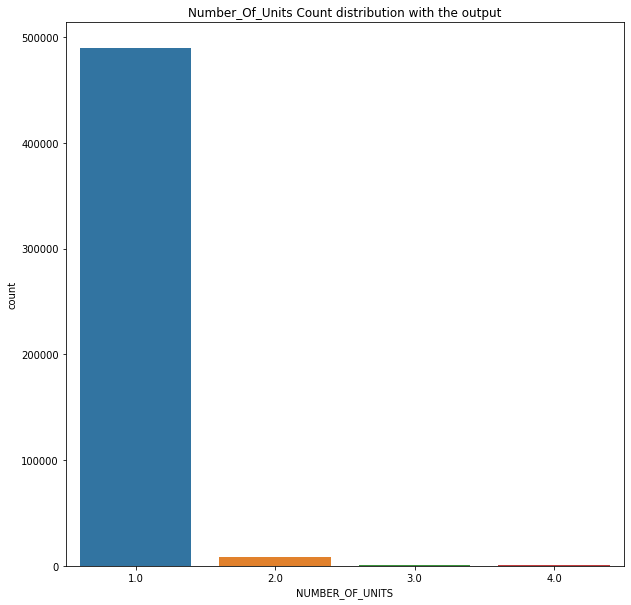

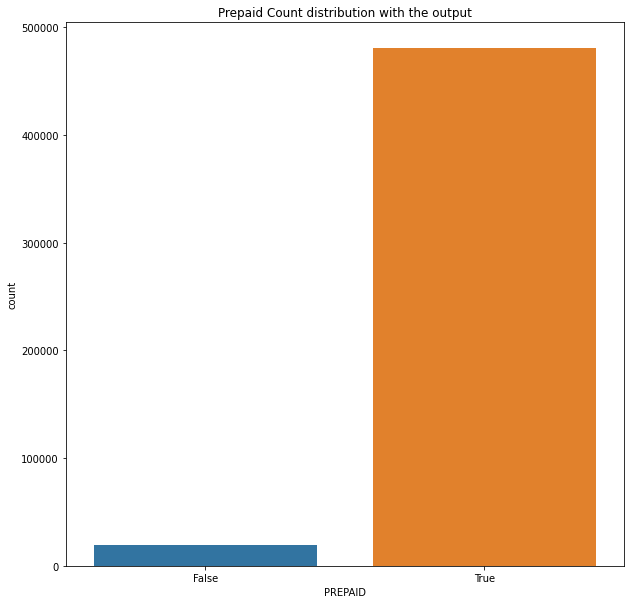

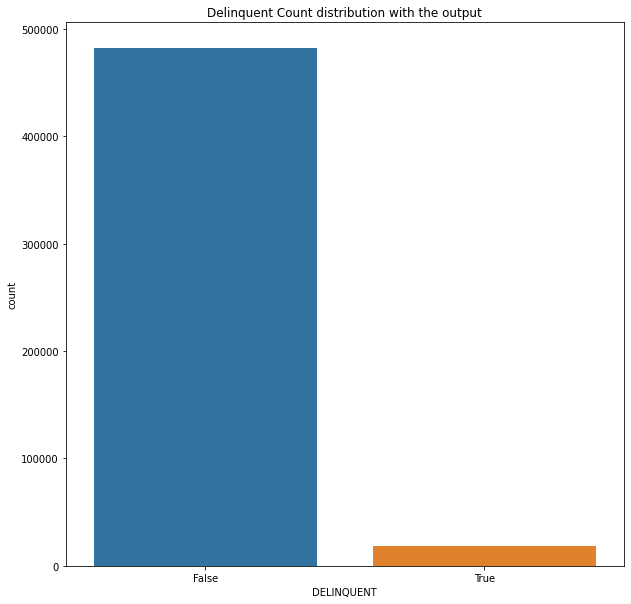

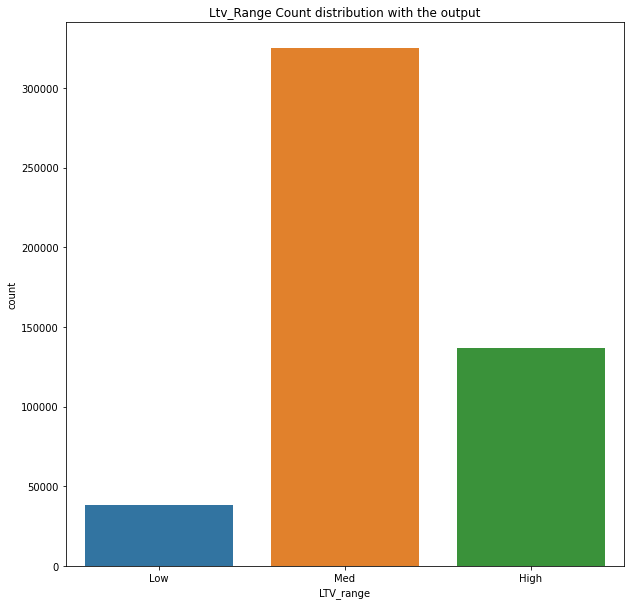

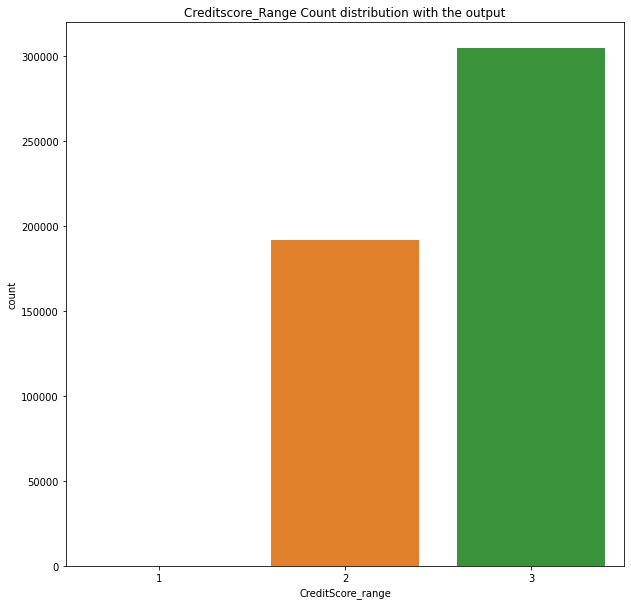

In [104]:
# calling the function for building count plot

feature_countplot(discrete_feature)

#### **Analysis:**

We have altogether 3 features with discrete value. Let's analyze them one by one:

* **NUMBER_OF_UNITS**
This feature altogether 4 values 

1 = one-unit
2 = two-unit
3 = three-unit
4 = four-unit

Most of the borrowers mortgage is one unit property compared to other units. Here we can see imbalance in the data units.

* **DELINQUENT**
Most of the borrowers hasn't reported any DELINQUENCY


#### **Observing the target variable**



In [105]:
mortgage_data['PREPAID'].value_counts()

True     480724
False     19413
Name: PREPAID, dtype: int64

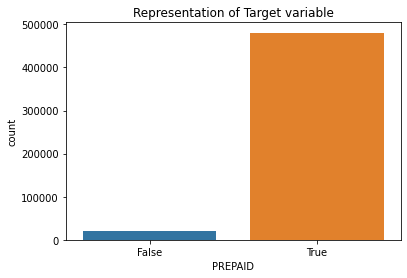

In [106]:
# visualizing using countplot

plt.title("Representation of Target variable")
sns.countplot(x ='PREPAID',data = mortgage_data)
plt.show()

In [107]:
## finding out the percentage

total_data = mortgage_data['PREPAID'].value_counts().sum()
total_data

500137

In [108]:
prepaid_data = 480724
non_prepaid_data  = 19143

prepaid_percent = (prepaid_data/total_data) * 100
print("The prepaid percentage is :\n",prepaid_percent)

non_prepaid_percent = (non_prepaid_data/total_data) * 100
print("The non-prepaid percentage is :\n",non_prepaid_percent)

The prepaid percentage is :
 96.11846354098978
The non-prepaid percentage is :
 3.8275512509572374


#### <b>Analysis: </b> 

We can clearly see the data imbalance here. As the number of prepaid is extremly higher than the non-prepaid data. i.e.** prepaid = 480724**, **non_prepaid = 19413**.**96%** of the data is prepaid and only **4%** of the data here is not-prepaid.

**Imbalalance data** can sometime affect our models performance and can bring biasness in our models performance. For e.g. In case of our data if we didn't handle the imbalance data then we might end up building a bias model with a lot of false positive value. That's quiet a problem. So we need to handle the imbalnce dataset using 

1. Undersampling of majority class label.
2. Oversampling of minority class label
3. Using SMOTE Technique which adds synthetic datapoints to our minority class label in order to balance the number of data points in each classes.

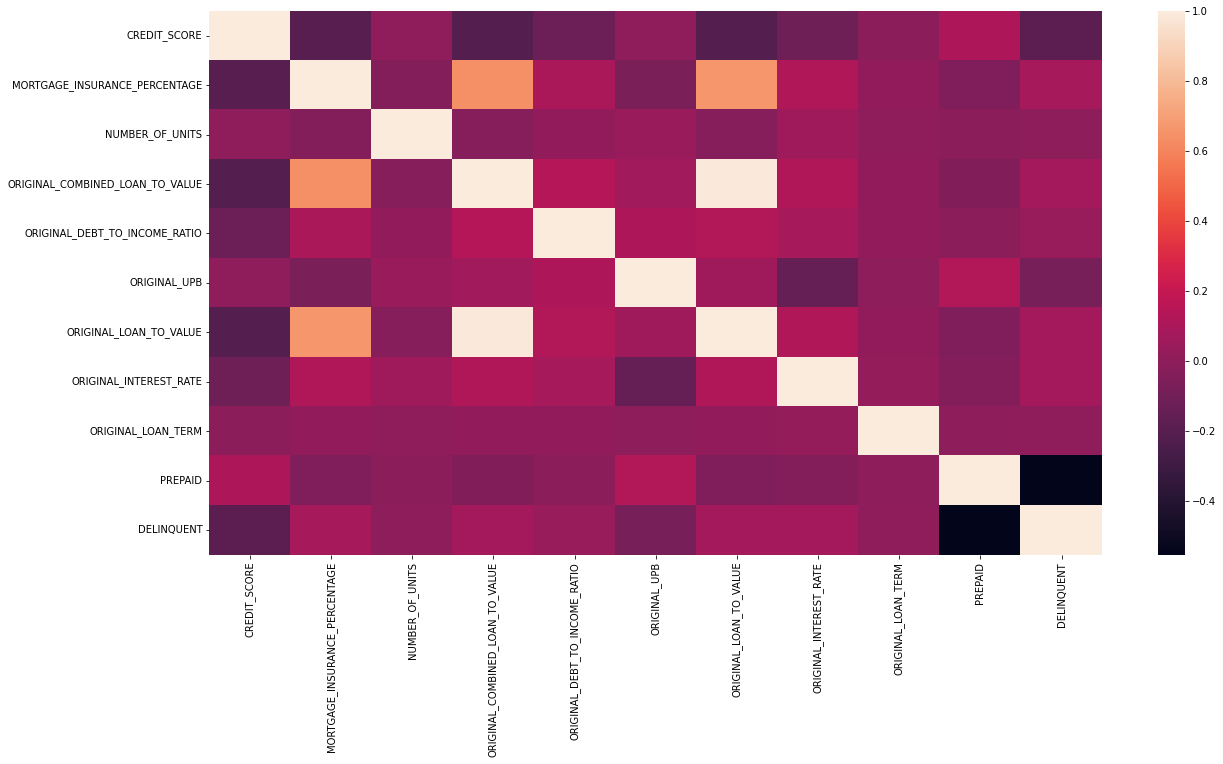

In [109]:
# Looking at the correlation of our numerical features and the output variable

plt.figure(figsize=(20,10))
sns.heatmap(mortgage_data.corr())

<b> Analysis: </b> 

Here from the above heat map we can see that   **'ORIGINAL_cOMBINED_LOAN_TO_VALUE'** is highly corelated with **'ORIGINAL_LOAN_TO_VALUE'** feature. likewise both **'ORIGINAL_LOAN_TO_VALUE'**,**'ORIGINAL_cOMBINED_LOAN_TO_VALUE'** has a strong correlation with **'MORTGAGE_INSURANCE_PERCENTAGE'** besides that we don't see much of strong correlation between 'PREPAID' and other features.

#### <b> Detecting outliers: </b>

What are outliers?

An outlier are data points that deviates significantly from the rest of the datapoints in a distribution. They can be caused by measurement or execution error.

Problem caused by an outlier ?

* Outliers in the data may causes problems during model fitting (esp. linear models).

* Outliers may inflate the error metrics which give higher weights to large errors (example, mean squared error, RMSE).

We can remove the outliers using different methods such as:

Inter quartile range
Z score method
Using percentile method

In [110]:
# defining a function that will create boxplot for all the continuous feature

def predict_outliers(cont_feature):
  for feature in cont_feature:
    data = mortgage_data.copy()
    sns.boxplot(y = data[feature])
    plt.ylabel(feature)
    plt.title(feature.title() + " " + "Distribution")
    plt.show()

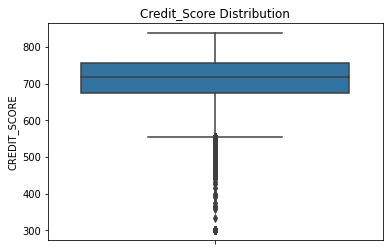

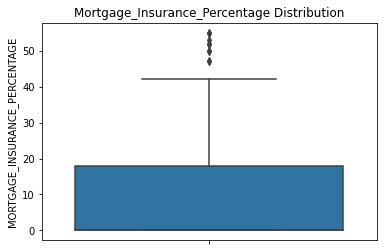

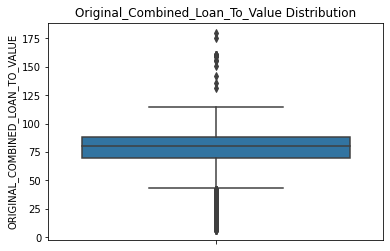

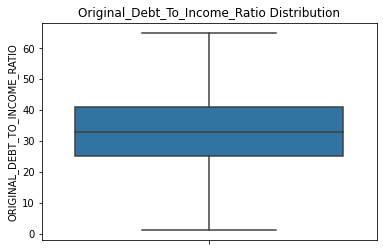

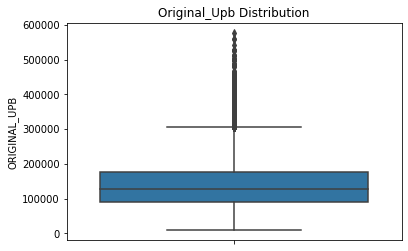

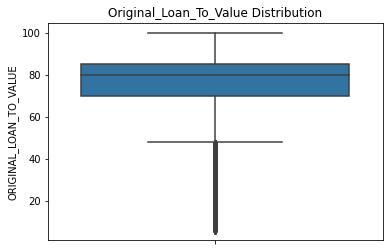

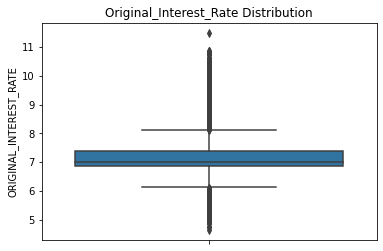

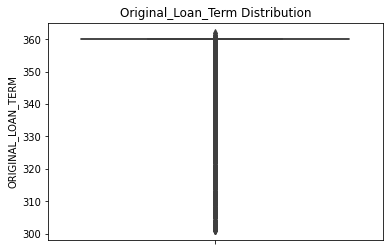

In [111]:
predict_outliers(continuous_feature)

#### <b> Analysis : </b>

On the basis of above boxplot we can a lot of outliers value present **'CREDIT_SCORE'**, **'ORIGINAL_COMBINED_LOAN_TO_VALUE'**, **'ORIGINAL_UPB'**,**'ORIGINAL_LOAN_TO_VALUE'**, **'ORIGINAL_INTEREST_RATE'** and **'ORIGINAL_LOAN_TERM'**.

In future these outliers can significantly reduce the model's performance but sometimes they might be useful. Once afterbuilding the preliminary model we can remove the outliers to see if it improves the model performance or not.

## <b> Data Pre-processing </b>

I will:

1. Drop unnecessary columns 
2. Do data cleaning
3. Handle categorical values
4. Transform data( scale, normalize the data, dimensionality reduction

In [112]:
# creating a new dataframe which will the copy of our original dataframe.


mortgage_data_copy = mortgage_data.copy()
mortgage_data.sample(10,random_state = 5)

,CREDIT_SCORE,FIRST_TIME_HOMEBUYER_FLAG,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,ORIGINAL_LOAN_TERM,PREPAID,DELINQUENT,LTV_range,CreditScore_range
247724,723.0,Y,0.0,1.0,60.0,23.0,130000,60.0,7.375,360,True,False,Med,3
157253,684.0,NaN,NaN,1.0,75.0,18.0,144000,75.0,6.750,360,True,False,Med,2
185189,708.0,NaN,0.0,1.0,70.0,NaN,240000,70.0,6.500,360,True,False,Med,3
305099,670.0,Y,0.0,1.0,80.0,36.0,156000,80.0,6.875,360,True,False,Med,2
39564,738.0,N,NaN,1.0,68.0,21.0,87000,68.0,6.875,360,True,False,Med,3
70402,789.0,N,0.0,1.0,77.0,28.0,227000,77.0,7.125,360,True,False,Med,3
24004,752.0,N,NaN,1.0,80.0,37.0,146000,80.0,7.125,360,True,False,Med,3
319136,686.0,NaN,0.0,1.0,80.0,33.0,148000,80.0,7.625,360,True,False,Med,2
398372,783.0,N,0.0,1.0,51.0,58.0,153000,51.0,7.250,360,True,False,Med,3
383710,747.0,N,0.0,1.0,55.0,41.0,155000,55.0,6.500,360,True,False,Med,3


## <b>DATA CLEANING</b>

### <b> Handling Missing Value </b>

Imputation is a very important way to manage the null values in the dataset. But sometimes imputation might not be always useful specially replacing the values in the feature with it's mean,median or mode value or frequently used value can be sometimes misleading. If you have less number of value in your dataset you can simply drop the rows with all the null values and see what actually happens. 

In case of our dataset we have 7 columns with missing rows.


* CREDIT_SCORE                         2711
* FIRST_TIME_HOMEBUYER_FLAG          130559
* MORTGAGE_INSURANCE_PERCENTAGE       51048
* NUMBER_OF_UNITS                         3
* ORIGINAL_COMBINED_LOAN_TO_VALUE        13
* ORIGINAL_DEBT_TO_INCOME_RATIO       14929
* ORIGINAL_LOAN_TO_VALUE                  9


Here, **FIRST_TIME_HOMEBUYER_FLAG** feature has maximum number of values and If we drop the rows which contains these null values we might lose lot of data. So, we need to find a decent way to manage the null value in these 2 features.

**SOLUTION:**

In case of **FIRST_TIME_HOMEBUYER_FLAG** I will replace all the null values with "others" which **means either the value is not available or the borrowers are not applicable**.

In case of remaining columns with null values we will simply **drop the rows containing these null values**.

In [113]:
# Firstly filling all the null values in FIRST_TIME_HOMEBUYER_FLAG with "O" which means others

mortgage_data_copy["FIRST_TIME_HOMEBUYER_FLAG"].fillna("O", inplace = True)
  

In [114]:
# Checking FIRST_TIME_HOMEBUYER_FLAG
 
mortgage_data_copy.FIRST_TIME_HOMEBUYER_FLAG.isnull().sum()

0

Successfully, mananged the null values in **FIRST_TIME_HOMEBUYER_FLAG** column.

In [115]:
# Looking at the no.of total rows in the data befor dropping the values

mortgage_data_copy.shape

(500137, 14)

In [116]:
# Let's drop all the rows with the null values

mortgage_data_copy.dropna(inplace = True)

In [117]:
# Looking at the no.of total rows in the data after dropping the values

mortgage_data_copy.shape

(431803, 14)

In [118]:
# Calculating the percentage of dropped rows

rows_before = 500137
rows_after = 432109

rows_lost = rows_before - rows_after
row_lostpercent = (rows_lost/rows_before)*100
print("The percentage of row lost", row_lostpercent)

The percentage of row lost 13.601873086774225


In [119]:
mortgage_data_copy.isnull().sum()

CREDIT_SCORE                       0
FIRST_TIME_HOMEBUYER_FLAG          0
MORTGAGE_INSURANCE_PERCENTAGE      0
NUMBER_OF_UNITS                    0
ORIGINAL_COMBINED_LOAN_TO_VALUE    0
ORIGINAL_DEBT_TO_INCOME_RATIO      0
ORIGINAL_UPB                       0
ORIGINAL_LOAN_TO_VALUE             0
ORIGINAL_INTEREST_RATE             0
ORIGINAL_LOAN_TERM                 0
PREPAID                            0
DELINQUENT                         0
LTV_range                          0
CreditScore_range                  0
dtype: int64

In [120]:
# Dividing the data into X and y

X= mortgage_data_copy.drop('PREPAID',axis = 1)  #Feature matrix
y = mortgage_data_copy['PREPAID']

### <b> Handaling categorical variables </b>

We know that our machine learning model only can work on the numerical value so it's really important to convert the categorical value in our dataset into some understandable numerical form so that it can be used for the training purpose.

We can follow different methods for handaling the categorical values in our dataset:

1. Label Encoding
2. One hot encoder

------------------------------------------------------------------------------

After dropping the columns in our dataset we have just 1 categorical features remaining after dropping i.e. 

* FIRST_TIME_HOMEBUYER_FLAG,


We will use one_hot encoding technique to encode our categorical feature. 

If we have categorical variables containing many multiple labels or high cardinality,then by using one hot encoding, we will expand the feature space dramatically.

One approach that is heavily used to solve this problem is to replace each label of the categorical variable by the count, this is the amount of times each label appears in the dataset. Or the frequency, this is the percentage of observations within that category. The 2 are equivalent.


In [121]:
# Apply one-hot encoder to each column with categorical data
low_cardinality_cols = ['FIRST_TIME_HOMEBUYER_FLAG','LTV_range']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

#One-hot-encode the categorical columns.
#Unfortunately outputs an array instead of dataframe.
array_hot_encoded = OH_encoder.fit_transform(X[low_cardinality_cols])

#Convert it to df
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=X.index)

#Extract only the columns that didnt need to be encoded
data_other_cols = X.drop(columns=low_cardinality_cols)

#Concatenate the two dataframes : 
X_clean_LCencoded_data = pd.concat([data_hot_encoded, data_other_cols], axis=1)

Successfully, handled the PROPERTY_STATE feature.

In [122]:
# Finally copying the data from X_clean_LCencoded_data to X_clean_encoded

X_encoded = X_clean_LCencoded_data.copy()

In [123]:
# Renaming column 0 and 1 as 'a' and 'b' respectively.

X_encoded.rename(columns = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f'},inplace = True)
X_encoded.head()

,a,b,c,d,e,f,CREDIT_SCORE,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,ORIGINAL_LOAN_TERM,DELINQUENT,CreditScore_range
0,1.0,0.0,0.0,0.0,0.0,1.0,669.0,0.0,1.0,80.0,33.0,162000,80.0,7.120,320,False,2
1,1.0,0.0,0.0,0.0,1.0,0.0,732.0,0.0,1.0,25.0,10.0,53000,25.0,6.500,360,False,3
2,1.0,0.0,0.0,1.0,0.0,0.0,679.0,30.0,1.0,91.0,48.0,133000,91.0,6.750,319,False,2
3,1.0,0.0,0.0,0.0,1.0,0.0,721.0,0.0,1.0,39.0,13.0,174000,39.0,6.625,318,False,3
4,1.0,0.0,0.0,1.0,0.0,0.0,618.0,25.0,1.0,85.0,24.0,122000,85.0,6.375,317,False,2


In [124]:
#Splitting the data
X_train,X_valid,y_train,y_valid = train_test_split(X_encoded,y,test_size= 0.2,random_state=0)

# Observing the shape of the training and testing data
print("The shape of X_train:", X_train.shape)
print("\nThe shape of X_valid:", X_valid.shape)
print("\nThe shape of y_train:", y_train.shape)
print("\nThe shape of y_valid:", y_valid.shape)

The shape of X_train: (345442, 17)

The shape of X_valid: (86361, 17)

The shape of y_train: (345442,)

The shape of y_valid: (86361,)


## <b> FEATURE SCALING </b> - Using StandardScalar

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range.

If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.

In our dataset we have features like 'METROPOLITAN_STATISTICAL_AREA' with huge range of value whereas 'MORTGAGE_INSURANCE_PERCENTAGE','ORIGINAL_LOAN_TO_VALUE' and so on has less range of value and in that case we require scaling of the data.

Here we will use <b>Standard Scalar</b> to scale our data. Minmax scaling scales the data between 0 and 1 using formula 

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

<b> z = (x - u) / s </b>

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

In [125]:
stdscale =StandardScaler().fit(X_train)
x_train_std = stdscale.transform(X_train)
X_valid_std = stdscale.transform(X_valid)

x_train_std.shape,X_valid_std.shape

((345442, 17), (86361, 17))

## **Building a preliminary model**

First of all I will build a preliminary model using the logistic regression algorithm . Then I will observe the models performance using different techniques and make necessary changes according the prediction.

In [138]:
# Model building using logistic regression
lr = LogisticRegression()

# Creating hyperparameter tuning for implementing cross validation
grid = {'C':10.0 ** np.arange(-2,3)}
cv = KFold(n_splits=5,shuffle= False,random_state = None)

clf = GridSearchCV(lr,grid,cv = cv,n_jobs = -1, scoring = 'accuracy')
clf.fit(x_train_std,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='accuracy')

**Description:** 

In the above preliminary model I simply called LogisticRegression() method from sklearn linear model and then I also implemented the **cross validation method** in order to validate the accuracy of my model. I used **GridSearchCV** to implement everything. 

**Cross Validation:**

Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

**GridSearchCV**

GridSearchCV is a function that comes in Scikit-learn’s(or SK-learn) model_selection package. This function helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, we can select the best parameters from the listed hyperparameters.


In [127]:
# doing necessary prediction on validation data and training data
predictionTrain = clf.predict(x_train_std)
prediction = clf.predict(X_valid_std)

# printing the accuracy score

print("The accuracy score of our training dataset is:",accuracy_score(y_train,predictionTrain))
print("The accuracy score of our validation dataset is:",accuracy_score(y_valid,prediction))

The accuracy score of our training dataset is: 0.9661592973639569
The accuracy score of our validation dataset is: 0.9652505181737127


**Analysis:** 
From above prediction we can say that the model's accuracy on both the training and validation dataset is almost the same which means there lies no problem of underfitting or overfitting.

**Underfitting**: 

Underfitting is a scenario in data science where a data model is unable to capture the relationship between the input and output variables accurately, generating a high error rate on both the training set and unseen data.To avoid underfitting we should

* Train our model on more dataset
* Properly clean our data before building any model
* Decrease Regularization
* Train on more feature

**Overfitting :** 

Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. If our model was overfitted we could have used the concept of **Regularization** to managae the overfitting. Besides that we can also use ensembling, removing features, training on more data, early stopping and many more.

In [128]:
# Defining a function that will do some performance analysis of given dataset

def performanceAnalysis(model,validation_x,validation_y,prediction):
  plot_confusion_matrix(model,validation_x,validation_y,values_format = 'd',display_labels= ["no prepaid","prepaid"])
  
  # Prining the classification report
  print(" Classification report")
  print(classification_report(validation_y,prediction))

 Classification report


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

       False       0.63      0.44      0.52      3656
        True       0.98      0.99      0.98     82705

    accuracy                           0.97     86361
   macro avg       0.80      0.71      0.75     86361
weighted avg       0.96      0.97      0.96     86361



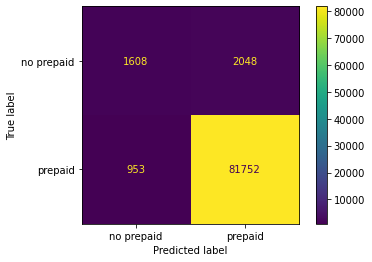

In [129]:
# Calling the function

performanceAnalysis(clf,X_valid_std,y_valid,prediction)


**Analysis:**

We have plotted a confusion metrics and build a classification report to study the performance of our model.

Let's understand them one by one

1. **Confusion Matrix**

In case of confusion metric we can see that our model is correctly able to classify **81752(True positive**) and **1608(True Negative)** Value. But we have pretty decent number of **False Negative(953)** and **False positive(2048)** falsely classified by our model. **In our case we need to try to reduce the number of false positive because classifying a non-prepaid value as prepaid can result in more loss to the bank** than the otherway analogy. Also our data is highly imbalanced that could also be one reason why our model is performing that way. So we will also try balancing out the data set to see if will get some improvement.

2. **Classification Report**

From the report it's clear that the value of precision, recall and  f1 score is quite low for the class label 0 whereas for class label 1 it's pretty high.



In [130]:
# Finding Roc-Auc score

# predicting probabilities
pred_prob1 = clf.predict_proba(X_valid_std)

# auc scores
auc_score1 = roc_auc_score(y_valid, pred_prob1[:,1])


print(auc_score1)




0.8886240370555917


**Analysis:**

We got actually a good ROC-AUC score of about is 89%. But as this a highly imbalanced dataset there is high chance that this score is a bias score.

In [131]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_valid, pred_prob1[:,1], pos_label=1)


# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_valid))]
p_fpr, p_tpr, _ = roc_curve(y_valid, random_probs, pos_label=1)

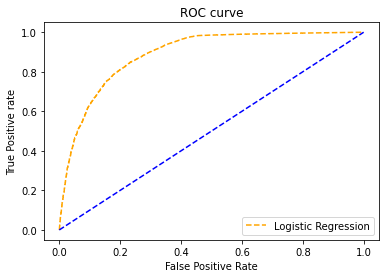

In [132]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')

# x label
plt.xlabel('False Positive Rate')

# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

So from the above graph we can say that if we need only care about the true +ve positive rate then we can use the threshold of 0.5 but if we want to reduce the true +ve rate we can also change the threshold value to the value something bigger than 0.5.

## **Balancing data 1st Method: Using oversampling**

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.



In [133]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os = RandomOverSampler(0.5)
X_train_ns,y_train_ns = os.fit_resample(x_train_std,y_train)
print("The number of classes before fit{}".format(Counter(y_train)))
print("The number of classes after fit{}".format(Counter(y_train_ns)))


/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


The number of classes before fitCounter({True: 330873, False: 14569})
The number of classes after fitCounter({True: 330873, False: 165436})


In [134]:
# After balancing again rebuilding our model

clf.fit(X_train_ns,y_train_ns)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='accuracy')

In [135]:
# doing necessary prediction on validation data
prediction1 = clf.predict(X_valid_std)

# printing the accuracy score
print("The accuracy score is:",accuracy_score(y_valid,prediction1))

The accuracy score is: 0.957527124512222


 Classification report


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

       False       0.50      0.57      0.53      3656
        True       0.98      0.97      0.98     82705

    accuracy                           0.96     86361
   macro avg       0.74      0.77      0.76     86361
weighted avg       0.96      0.96      0.96     86361



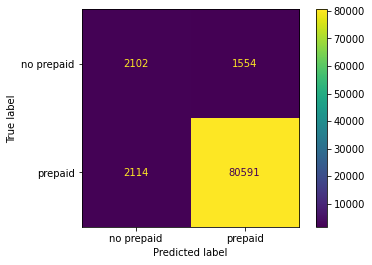

In [136]:
# calling the function that executes the plotting of confusion matrix and classification report

performanceAnalysis(clf,X_valid_std,y_valid,prediction1)

**Analyis:**

After balancing the data we could see slight increase in the score of recall and f1 score and we have lesser number of false positive as well.

## **Balancing data 2nd Method: Using SMOTE**


**SMOTE** is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

In [143]:
from imblearn.combine import SMOTETomek


os = SMOTETomek(0.75)

# Taking only 50000 points from the training dataset
X_train_ns1 = x_train_std[0:50000]
y_train_ns1 = y_train[0:50000]

X_train_ns1,y_train_ns1 = os.fit_resample(X_train_ns1,y_train_ns1)
print("The number of classes before fit{}".format(Counter(y_train)))
print("The number of classes after fit{}".format(Counter(y_train_ns1)))

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.75 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


The number of classes before fitCounter({True: 330873, False: 14569})
The number of classes after fitCounter({True: 47581, False: 35616})


we have a lot of data and if we take in account the entire datat then definately SMOTE will take forever to run so we only took 50000 sample data in order to see the performance of our oversampler.

In [144]:
# Training the model
clf.fit(X_train_ns1,y_train_ns1)



GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='accuracy')

In [145]:
# doing necessary prediction on validation data
prediction2 = clf.predict(X_valid_std)

# printing the accuracy score
print("The accuracy score is:",accuracy_score(y_valid,prediction2))

The accuracy score is: 0.9084193096420838


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 Classification report
              precision    recall  f1-score   support

       False       0.27      0.67      0.38      3656
        True       0.98      0.92      0.95     82705

    accuracy                           0.91     86361
   macro avg       0.63      0.80      0.67     86361
weighted avg       0.95      0.91      0.93     86361



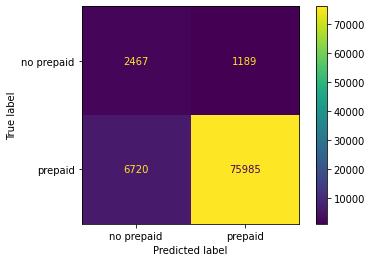

In [146]:
performanceAnalysis(clf,X_valid_std,y_valid,prediction2)

**Analysis:**

From the analysis we see that we have incresed the decresed the number of true +ve. The recall has incresed but their is a significant decrese in the value of precision which resulted in small f1 score less than 50.
